In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from models import createSimpleModel
from animate import *

In [3]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [7]:
def computemjj_pd(event):
    px1 = np.array(event['pxj1'])
    py1 = np.array(event['pyj1'])
    pz1 = np.array(event['pzj1'])
    mj1 = np.array(event['mj1'])
    Ej1 = np.sqrt((px1**2 + py1**2 + pz1**2) + mj1**2)

    px2 = np.array(event['pxj2'])
    py2 = np.array(event['pyj2'])
    pz2 = np.array(event['pzj2'])
    mj2 = np.array(event['mj2'])
    Ej2 = np.sqrt((px2**2 + py2**2 + pz2**2) + mj2**2)

    p4_j1 = np.array([px1, py1, pz1, Ej1]).transpose()
    p4_j2 = np.array([px2, py2, pz2, Ej2]).transpose()
    
    p4_jj = p4_j1 + p4_j2
    mjj = np.sqrt((p4_jj**2 * np.array([-1, -1, -1, 1])).sum(axis=1))
    return mjj

In [8]:
import awkward as ak
mjj = computemjj_pd(df_QCD)
ak.to_numpy((mjj>3300) & (mjj <3700)).sum()

121352

In [9]:
mjj

array([3307.21938744, 3107.62060343, 3004.89527209, ..., 3021.08344341,
       4283.54500244, 2784.05801619])

In [15]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

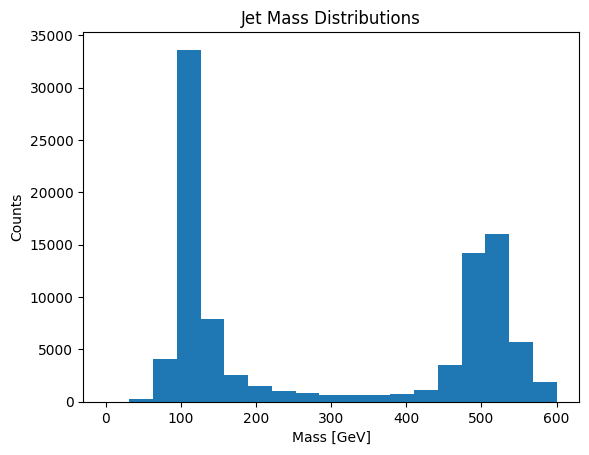

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [112]:
# def computemjj_pd(event):
#     px1 = event[["pxj1"]].to_numpy()
#     py1 = event[["pyj1"]].to_numpy()
#     pz1 = event[["pzj1"]].to_numpy()
#     pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
#     px2 = event[["pxj2"]].to_numpy()
#     py2 = event[["pyj2"]].to_numpy()
#     pz2 = event[["pzj2"]].to_numpy()
#     pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
#     m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
#     return np.array(np.sqrt(m2)).flatten()

In [115]:
computemjj_pd(df_QCD)

/tmp/ipykernel_340405/3658239227.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.array(np.sqrt(m2)).flatten()


array([3355.02554618, 2339.42558763, 2476.53829533, ..., 3867.9955467 ,
       2882.70480346, 2279.14046694])

In [50]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [4]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

epsilon = 1e-6
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+epsilon))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+epsilon))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+epsilon),stau2_m_m/(stau1_m_m+epsilon)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array_order1", x_array)

In [5]:
x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [6]:
np.shape(x[0,0])

(121352, 4)

In [6]:
x_data_100 = np.concatenate([x[0,0],x[1,1]])
y_data_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_data_100, y_data_100, test_size=0.5)

In [48]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Dedicated_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "layer_2": 256,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
    },
    dir=pscratch_dir
)

config = wandb.config

In [49]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
#model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               2560      
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [50]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [51]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=config.epoch,
                                validation_data=(X_val_100, Y_val_100),
                                batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
68/97 [====================>.........] - ETA: 0s - loss: 0.1063 - accuracy: 0.8560INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 10ms/step - loss: 0.0997 - accuracy: 0.8657 - val_loss: 0.0822 - val_accuracy: 0.8896
Epoch 2/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0794 - accuracy: 0.8944INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0782 - accuracy: 0.8952 - val_loss: 0.0737 - val_accuracy: 0.9015
Epoch 3/1000
88/97 [==========================>...] - ETA: 0s - loss: 0.0689 - accuracy: 0.9063INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0689 - accuracy: 0.9061 - val_loss: 0.0644 - val_accuracy: 0.9111
Epoch 4/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9105INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0638 - accuracy: 0.9123 - val_loss: 0.0608 - val_accuracy: 0.9160
Epoch 5/1000
67/97 [===================>..........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9151INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0619 - accuracy: 0.9148 - val_loss: 0.0604 - val_accuracy: 0.9166
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.9143 - val_loss: 0.0614 - val_accuracy: 0.9147
Epoch 7/1000
65/97 [===================>..........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9151INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0615 - accuracy: 0.9151 - val_loss: 0.0598 - val_accuracy: 0.9168
Epoch 8/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9157 - val_loss: 0.0619 - val_accuracy: 0.9138
Epoch 9/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9156 - val_loss: 0.0602 - val_accuracy: 0.9161
Epoch 10/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9151 - val_loss: 0.0610 - val_accuracy: 0.9161
Epoch 11/1000
93/97 [===========================>..] - ETA: 0s - loss: 0.0609 - accuracy: 0.9155INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0609 - accuracy: 0.9155 - val_loss: 0.0597 - val_accuracy: 0.9174
Epoch 12/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0615 - accuracy: 0.9147INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 13ms/step - loss: 0.0606 - accuracy: 0.9162 - val_loss: 0.0595 - val_accuracy: 0.9177
Epoch 13/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9157 - val_loss: 0.0596 - val_accuracy: 0.9174
Epoch 14/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9163 - val_loss: 0.0601 - val_accuracy: 0.9168
Epoch 15/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9163 - val_loss: 0.0600 - val_accuracy: 0.9168
Epoch 16/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9156 - val_loss: 0.0601 - val_accuracy: 0.9168
Epoch 17/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9161 - val_loss: 0.0606 - val_accuracy: 0.9158
Epoch 18/1000
88/97 [==========================>...] - ETA: 0s - loss: 0.0609 - accuracy: 0.9153INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9156 - val_loss: 0.0594 - val_accuracy: 0.9175
Epoch 19/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9165 - val_loss: 0.0601 - val_accuracy: 0.9165
Epoch 20/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9166 - val_loss: 0.0597 - val_accuracy: 0.9174
Epoch 21/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9162 - val_loss: 0.0598 - val_accuracy: 0.9173
Epoch 22/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0603 - accuracy: 0.9166 - val_loss: 0.0606 - val_accuracy: 0.9157
Epoch 23/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9163 - val_loss: 0.0601 - val_accuracy: 0.9167
Epoch 24/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.9167 - val_loss: 0.0596 - val_accuracy: 0.9173
Epoch 25/100

In [52]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▇████████████████████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆██▇█▇█████████████▇██████
val_loss,█▅▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.91676
best_epoch,17
best_val_loss,0.05944
epoch,27
loss,0.06022
val_accuracy,0.91689


In [7]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2023-11-15 14:26:47.851303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:26:48.528032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12293 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=100,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9190 - val_loss: 0.1905 - val_accuracy: 0.9201
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9194 - val_loss: 0.1890 - val_accuracy: 0.9206
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9198 - val_loss: 0.1891 - val_accuracy: 0.9208
Epoch 4/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9191 - val_loss: 0.1888 - val_accuracy: 0.9213
Epoch 5/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9199 - val_loss: 0.1884 - val_accuracy: 0.9211
Epoch 6/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9190 - val_loss: 0.1893 - val_accuracy: 0.9207
Epoch 7/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9195 - val_loss: 0.1883 - val_accuracy: 0.9206

In [34]:
wandb.finish()

In [53]:
model_dedicated.save("model_100_BCE")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_100_BCE/assets


In [59]:
preds_mm_list = []

tuple_rates_dedicated_ordered_BCE = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 3 and j == 3) or (i == 6 and j == 6):
            print(i,j)
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(512, input_dim=4, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_BCE[tuple((i, j))] = [fpr_mm, tpr_mm]

0.5 0.5
Epoch 1/1000
192/192 [==============================] - 2s 6ms/step - loss: 0.2920 - accuracy: 0.8740 - val_loss: 0.2710 - val_accuracy: 0.8852
Epoch 2/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8874 - val_loss: 0.2613 - val_accuracy: 0.8931
Epoch 3/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2588 - accuracy: 0.8922 - val_loss: 0.2572 - val_accuracy: 0.8919
Epoch 4/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8930 - val_loss: 0.2545 - val_accuracy: 0.8939
Epoch 5/1000
192/192 [==============================] - 1s 6ms/step - loss: 0.2557 - accuracy: 0.8927 - val_loss: 0.2544 - val_accuracy: 0.8944
Epoch 6/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2555 - accuracy: 0.8927 - val_loss: 0.2522 - val_accuracy: 0.8950
Epoch 7/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2553 - accuracy: 0.8933 - val_loss: 0.2530 - val_a

In [60]:
len(tuple_rates_dedicated_BCE_Optimized)

4

In [61]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
np.save("tuple_rates_dedicated_BCE", tuple_rates_dedicated_BCE)

#fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [62]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [114]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

144

In [65]:
preds_all_BCE_50 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1],batch_size=1000)
fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1], preds_all_BCE_50)

99/99 [==============================] - 0s 756us/step


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


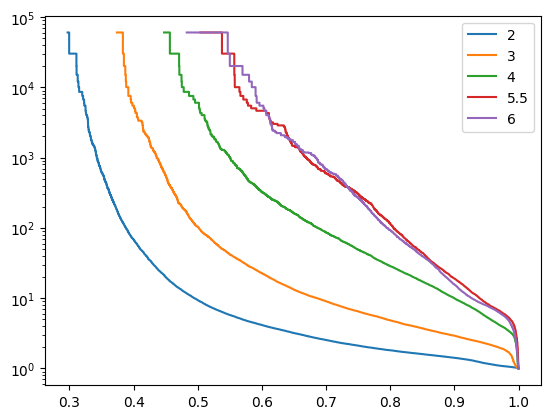

In [181]:
for m in [2, 3, 4, 5.5, 6]:
    something = X_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    plt.legend()
    plt.yscale("log")

In [174]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(98560, 2)

In [172]:
np.shape(something[:,4:6])

(98560, 2)

In [63]:
preds_all_BCE_100 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

87/87 [==============================] - 0s 757us/step


In [64]:
tuple_rates_dedicated_BCE_Optimized.keys()

dict_keys([(0.5, 0.5), (1, 1), (3, 3), (6, 6)])

Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

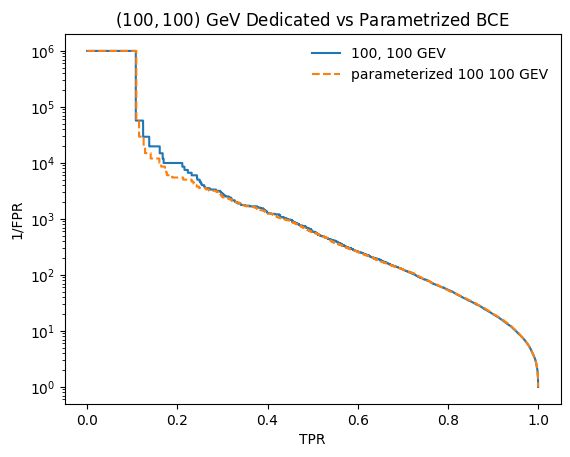

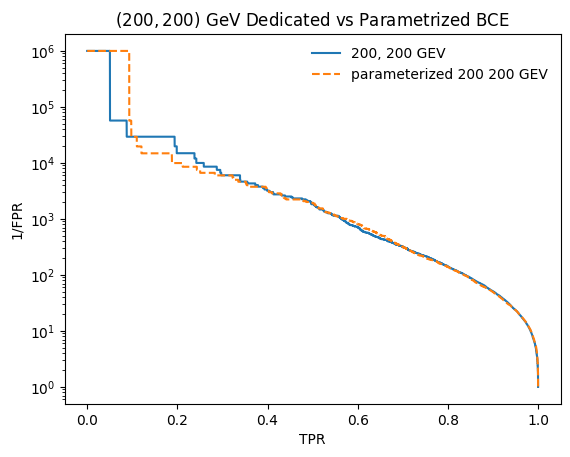

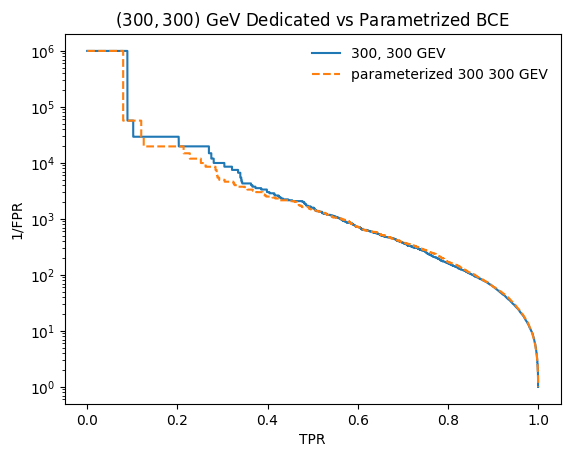

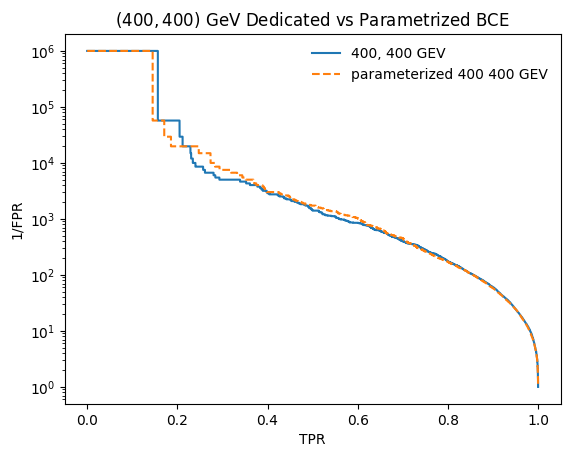

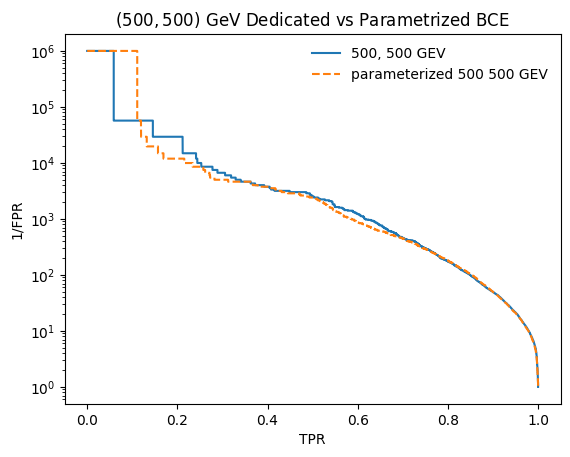

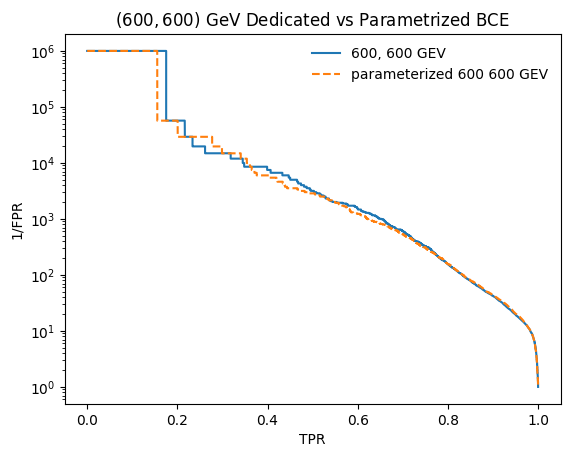

In [116]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

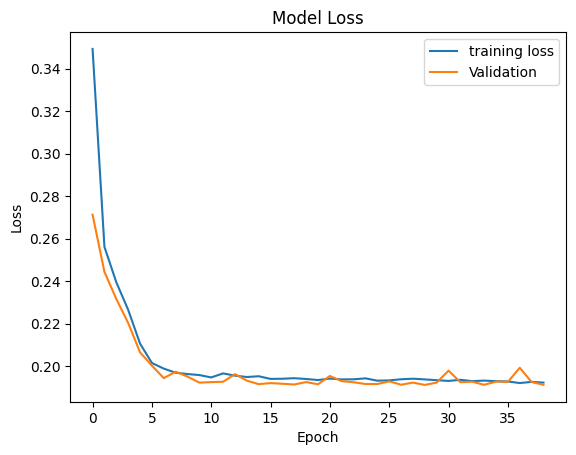

In [153]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


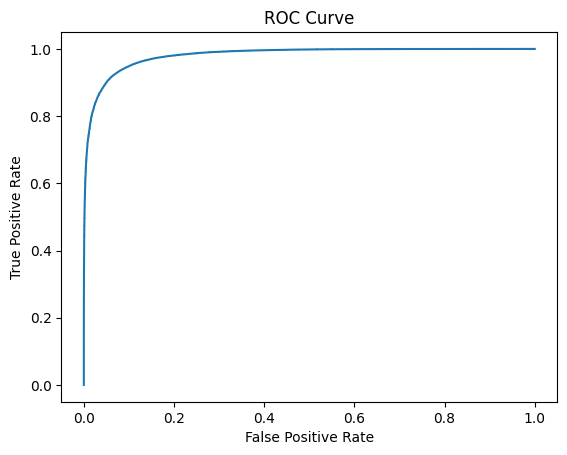

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [13]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all_fixed",x_vals_all)
    np.save("y_vals_all_fixed",y_vals_all)

In [7]:
x_vals_all = np.load("x_vals_all_fixed.npy")
y_vals_all = np.load("y_vals_all_fixed.npy")

In [8]:
np.shape(x_vals_all)

(27249420, 6)

In [9]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [18]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Parametrized_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    },
    dir = pscratch_dir
)

config_parametrized = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▆▇▆█▆█▇▇██
val_loss,█▃▂▂▂▃▂▂▁▂▁▂▂▁▁
accuracy,0.9339
best_epoch,14
best_val_loss,0.16763
epoch,14
loss,0.16797
val_accuracy,0.934


In [19]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
with tf.device('/GPU:0'):
    myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

Epoch 1/1000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9227INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1962 - accuracy: 0.9227 - val_loss: 0.1780 - val_accuracy: 0.9303
Epoch 2/1000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9320INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1734 - accuracy: 0.9320 - val_loss: 0.1711 - val_accuracy: 0.9329
Epoch 3/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1712 - accuracy: 0.9327 - val_loss: 0.1736 - val_accuracy: 0.9314
Epoch 4/1000
2645/2662 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9330INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1703 - accuracy: 0.9330 - val_loss: 0.1698 - val_accuracy: 0.9331
Epoch 5/1000
2645/2662 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9332INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1698 - accuracy: 0.9332 - val_loss: 0.1695 - val_accuracy: 0.9332
Epoch 6/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1694 - accuracy: 0.9334 - val_loss: 0.1699 - val_accuracy: 0.9332
Epoch 7/1000
2641/2662 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1691 - accuracy: 0.9335 - val_loss: 0.1689 - val_accuracy: 0.9337
Epoch 8/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1689 - accuracy: 0.9335 - val_loss: 0.1691 - val_accuracy: 0.9334
Epoch 9/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1687 - accuracy: 0.9335 - val_loss: 0.1693 - val_accuracy: 0.9334
Epoch 10/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.1722 - val_accuracy: 0.9322
Epoch 11/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1684 - accuracy: 0.9337 - val_loss: 0.1693 - val_accuracy: 0.9334
Epoch 12/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1683 - accuracy: 0.9338 - val_loss: 0.1689 - val_accuracy: 0.9335


In [22]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇████████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▃▇▇▇█▇▇▅▇█
val_loss,█▃▅▂▂▂▁▁▁▄▁▁
accuracy,0.93376
best_epoch,6
best_val_loss,0.16886
epoch,11
loss,0.16829
val_accuracy,0.93349


In [24]:
model_all.save("model_all_BCE")
#model_all.save("model_all_MSE_Fixed_3_512")

INFO:tensorflow:Assets written to: model_all_BCE/assets


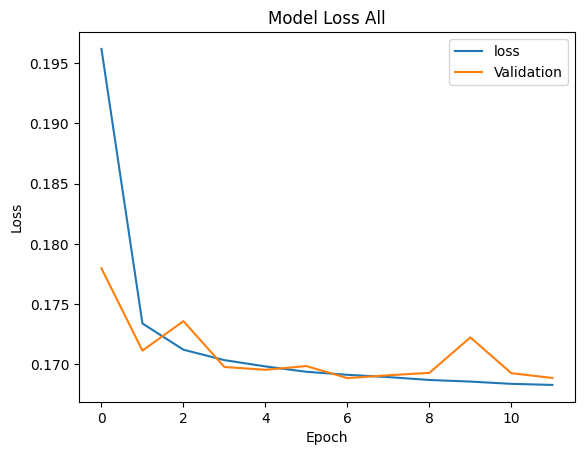

In [23]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [129]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

100/100 [==============================] - 0s 690us/step


In [5]:
#model_all_BCE = tf.keras.models.load_model("model_all_ordered_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [102]:
#preds_all_MSE = model_all_MSE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
#fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

99/99 [==============================] - 0s 2ms/step


In [130]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 675us/step


/tmp/ipykernel_808700/2993218434.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
/tmp/ipykernel_808700/2993218434.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)')

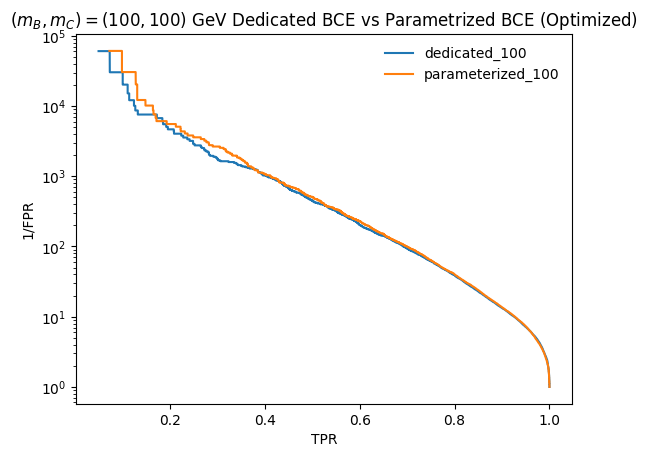

In [131]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)")

In [82]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [19]:
model_all_BCE = tf.keras.models.load_model("model_all_BCE_Fixed")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [21]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1)
            model32 = createSimpleModel(4)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

In [95]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [ 0.52852035 10.807516  ]
[0.5 1. ] [1.1410923 8.681716 ]
[0.5 1.5] [1.7087789 9.502621 ]
[0.5 2. ] [2.209993 9.610666]
[0.5 2.5] [2.634493  2.4807847]
[1.  0.5] [1.1314318 8.826323 ]
[1. 1.] [1.0516274 8.336853 ]
[1.  1.5] [1.5585779 8.746403 ]
[1. 2.] [2.1806989 9.658493 ]
[1.  2.5] [2.613276  2.4700634]
[1.5 0.5] [1.714507 9.539725]
[1.5 1. ] [1.5685513 8.818821 ]
[2.  0.5] [2.1968632 9.525651 ]
[2. 1.] [2.1850243 9.7158575]
[2.5 0.5] [2.6377742 2.5102966]
[2.5 1. ] [2.6152718 2.4667516]
[3.  0.5] [3.2449262 3.019374 ]
[5.5 0.5] [0.2262814 5.619852 ]
[6.  0.5] [6.015816  6.1012135]
found both: 0.8680555555555556
found one: 0.1111111111111111
found none: 0.020833333333333332


In [22]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [38]:
m1_list == np.array(mass_range[1:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [139]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

In [43]:
np.shape(x[0,0])

(121352, 4)

3.241 3.649 0.001
30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 7ms/step - loss: 0.6996 - val_loss: 0.6997
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6980 - val_loss: 0.6985
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6969 - val_loss: 0.6975
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6961 - val_loss: 0.6967
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6955 - val_loss: 0.6962
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6951 - val_loss: 0.6958
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6948 - val_loss: 0.6954
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6945 - val_loss: 0.6951
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6943 - val_loss: 0.6948
Epoch 10/50
30/30 [==============================] - 0s 3ms/ste

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.7001 - val_loss: 0.6990
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6987 - val_loss: 0.6979
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6976 - val_loss: 0.6970
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6963
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6962 - val_loss: 0.6958
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6957 - val_loss: 0.6952
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6953 - val_loss: 0.6949
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6950 - val_loss: 0.6946
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6947 - val_loss: 0.6944
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6945 - val_loss: 0.6942
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6988 - val_loss: 0.7001
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6974 - val_loss: 0.6989
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6965 - val_loss: 0.6978
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6958 - val_loss: 0.6971
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6953 - val_loss: 0.6965
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6949 - val_loss: 0.6960
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6946 - val_loss: 0.6956
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6953
Epoch 9/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6951
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6949
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6996 - val_loss: 0.6991
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6982 - val_loss: 0.6978
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6972 - val_loss: 0.6969
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6965 - val_loss: 0.6962
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6960 - val_loss: 0.6957
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.6953
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6953 - val_loss: 0.6949
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6947
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6948 - val_loss: 0.6945
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6943
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6998 - val_loss: 0.6993
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6984 - val_loss: 0.6981
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6973 - val_loss: 0.6973
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6964 - val_loss: 0.6965
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6957 - val_loss: 0.6960
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6951 - val_loss: 0.6956
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6953
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6950
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6940 - val_loss: 0.6948
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6938 - val_loss: 0.6946
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6996 - val_loss: 0.6993
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6981 - val_loss: 0.6981
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6971 - val_loss: 0.6972
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6964 - val_loss: 0.6965
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6957 - val_loss: 0.6959
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6952 - val_loss: 0.6954
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6951
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6948
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6946
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6944
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6988 - val_loss: 0.7000
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6976 - val_loss: 0.6989
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6967 - val_loss: 0.6980
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6960 - val_loss: 0.6974
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6954 - val_loss: 0.6968
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6964
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6959
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6956
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6953
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6939 - val_loss: 0.6951
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 8ms/step - loss: 0.6990 - val_loss: 0.6998
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6978 - val_loss: 0.6987
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6979
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6961 - val_loss: 0.6972
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.6967
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6952 - val_loss: 0.6963
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6959
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6947 - val_loss: 0.6956
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6954
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6952
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 8ms/step - loss: 0.7002 - val_loss: 0.6986
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6988 - val_loss: 0.6975
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6978 - val_loss: 0.6967
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6970 - val_loss: 0.6960
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6963 - val_loss: 0.6955
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.6952
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6955 - val_loss: 0.6949
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6952 - val_loss: 0.6946
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6944
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6947 - val_loss: 0.6942
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6985 - val_loss: 0.7001
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6974 - val_loss: 0.6989
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6965 - val_loss: 0.6980
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.6973
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6954 - val_loss: 0.6966
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6961
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6956
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6952
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6948
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6940 - val_loss: 0.6946
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 8ms/step - loss: 0.6994 - val_loss: 0.6989
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6980 - val_loss: 0.6980
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6969 - val_loss: 0.6971
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6962 - val_loss: 0.6964
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.6958
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6952 - val_loss: 0.6954
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6948 - val_loss: 0.6950
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6947
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6945
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6943
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6985 - val_loss: 0.6994
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6973 - val_loss: 0.6983
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6964 - val_loss: 0.6974
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6958 - val_loss: 0.6967
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6952 - val_loss: 0.6960
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6948 - val_loss: 0.6954
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6950
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6946
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.6942
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6935 - val_loss: 0.6939
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6998 - val_loss: 0.6981
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6984 - val_loss: 0.6971
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6974 - val_loss: 0.6963
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6965 - val_loss: 0.6957
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.6952
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6953 - val_loss: 0.6948
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6945
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6946 - val_loss: 0.6943
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6941
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6940
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6977 - val_loss: 0.6994
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6965 - val_loss: 0.6981
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.6972
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6961
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6954
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6938 - val_loss: 0.6948
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6943
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6938
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6928 - val_loss: 0.6934
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6923 - val_loss: 0.6927
Epoch 11/50
30/30 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6989 - val_loss: 0.6980
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6976 - val_loss: 0.6970
Epoch 3/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6963
Epoch 4/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6961 - val_loss: 0.6957
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6955 - val_loss: 0.6951
Epoch 6/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6951 - val_loss: 0.6947
Epoch 7/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6947 - val_loss: 0.6943
Epoch 8/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6943 - val_loss: 0.6938
Epoch 9/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6939 - val_loss: 0.6934
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6928
Epoch 11/50
31/31 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6978 - val_loss: 0.6983
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6960 - val_loss: 0.6967
Epoch 3/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6947 - val_loss: 0.6952
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6939
Epoch 5/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6926 - val_loss: 0.6924
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6908
Epoch 7/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6899 - val_loss: 0.6890
Epoch 8/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6884 - val_loss: 0.6878
Epoch 9/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6872 - val_loss: 0.6876
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6869 - val_loss: 0.6876
Epoch 11/50
31/31 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6975 - val_loss: 0.6981
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6958 - val_loss: 0.6964
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6941 - val_loss: 0.6942
Epoch 4/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6918 - val_loss: 0.6912
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6885 - val_loss: 0.6882
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6860 - val_loss: 0.6863
Epoch 7/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6851 - val_loss: 0.6856
Epoch 8/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6847 - val_loss: 0.6855
Epoch 9/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6847 - val_loss: 0.6855
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6846 - val_loss: 0.6854
Epoch 11/50
31/31 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6973 - val_loss: 0.6974
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6960 - val_loss: 0.6958
Epoch 3/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6934
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6914 - val_loss: 0.6895
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6875 - val_loss: 0.6852
Epoch 6/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6836 - val_loss: 0.6824
Epoch 7/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6824 - val_loss: 0.6822
Epoch 8/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.6822
Epoch 9/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6822 - val_loss: 0.6822
Epoch 10/50
31/31 [==============================] - 0s 3ms/step - loss: 0.6822 - val_loss: 0.6822
Epoch 11/50
31/31 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 8ms/step - loss: 0.6966 - val_loss: 0.6961
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6929
Epoch 3/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6888 - val_loss: 0.6871
Epoch 4/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6826 - val_loss: 0.6812
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6788 - val_loss: 0.6791
Epoch 6/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6781 - val_loss: 0.6790
Epoch 7/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6780 - val_loss: 0.6789
Epoch 8/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6779 - val_loss: 0.6789
Epoch 9/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6779 - val_loss: 0.6789
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6779 - val_loss: 0.6788
Epoch 11/50
31/31 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


32/32 [==============================] - 1s 7ms/step - loss: 0.6962 - val_loss: 0.6944
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6937 - val_loss: 0.6907
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6876 - val_loss: 0.6826
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6767 - val_loss: 0.6753
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6728 - val_loss: 0.6747
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6727 - val_loss: 0.6746
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6726 - val_loss: 0.6745
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6726 - val_loss: 0.6745
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6726 - val_loss: 0.6744
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6726 - val_loss: 0.6744
Epoch 11/50
32/32 [===========

/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/1718604246.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


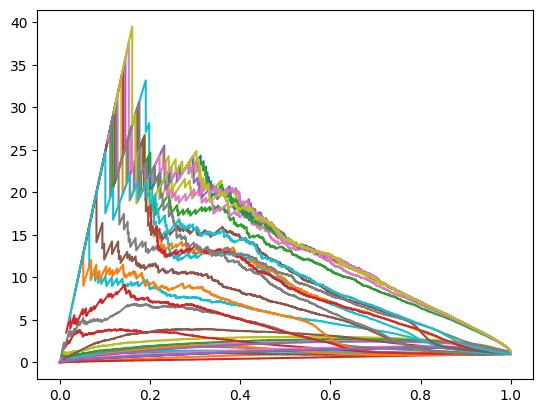

In [64]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []
epsilon = 1e-6

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)
    
    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1.+sigfrac*LLR
    LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    backtoprob = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = backtoprob)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 2
    m2 = 4.5

    test_set_back = int(len(x[0,0])*0.5)
    train_set_reference = int(len(x[0,0])*0.25)
    train_set_data = len(x[0,0]) - test_set_back - train_set_reference
    test_set_sig = int(len(x[m1,m2])*0.5)
    sig_frac = sigfrac

    tot = train_set_reference
    x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
    y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

    print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
    
    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)    
    
    #Now, let's do weakly supervised learning.
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

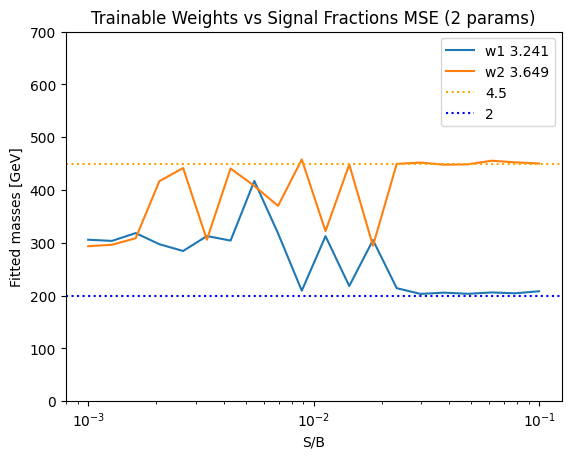

In [65]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'max SIC')

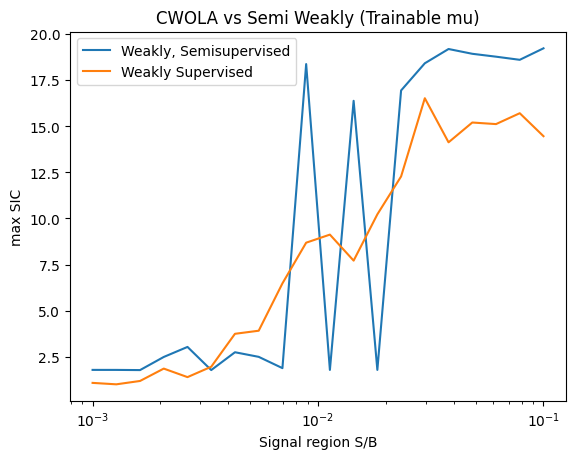

In [66]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

2.405 3.493 0.001
30338 91014 30 0.0009888588568791614
Epoch 1/35
30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/ste

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6930
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6934
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 3/35
30/30 [==============================] - 0s 5ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6928 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6928 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6934
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6928
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6928
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - val_loss: 0.6926
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6929 - val_loss: 0.6923
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6926 - val_loss: 0.6920
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6923 - val_loss: 0.6920
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6923 - val_loss: 0.6920
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6934 - val_loss: 0.6929
Epoch 2/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6927
Epoch 3/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6916 - val_loss: 0.6921
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6913 - val_loss: 0.6921
Epoch 6/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6921
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6913 - val_loss: 0.6921
Epoch 8/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6921
Epoch 9/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6921
Epoch 10/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6922
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6929
Epoch 2/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 3/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6910 - val_loss: 0.6916
Epoch 4/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6903 - val_loss: 0.6915
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6901 - val_loss: 0.6915
Epoch 6/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6901 - val_loss: 0.6914
Epoch 7/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6901 - val_loss: 0.6914
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6901 - val_loss: 0.6914
Epoch 9/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6901 - val_loss: 0.6914
Epoch 10/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6901 - val_loss: 0.6914
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 2/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6920 - val_loss: 0.6919
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6909 - val_loss: 0.6902
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6898 - val_loss: 0.6898
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6896 - val_loss: 0.6898
Epoch 6/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6896 - val_loss: 0.6898
Epoch 7/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6896 - val_loss: 0.6898
Epoch 8/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6895 - val_loss: 0.6897
Epoch 9/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6896 - val_loss: 0.6897
Epoch 10/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6896 - val_loss: 0.6898
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6928 - val_loss: 0.6917
Epoch 2/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6907 - val_loss: 0.6891
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6885 - val_loss: 0.6879
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6876 - val_loss: 0.6863
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6853 - val_loss: 0.6830
Epoch 6/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6830 - val_loss: 0.6814
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6823 - val_loss: 0.6812
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6822 - val_loss: 0.6812
Epoch 9/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6822 - val_loss: 0.6813
Epoch 10/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6822 - val_loss: 0.6812
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6918 - val_loss: 0.6907
Epoch 2/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6888 - val_loss: 0.6868
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6860 - val_loss: 0.6854
Epoch 4/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6842 - val_loss: 0.6820
Epoch 5/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6806 - val_loss: 0.6785
Epoch 6/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6785 - val_loss: 0.6781
Epoch 7/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6782 - val_loss: 0.6781
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6782 - val_loss: 0.6781
Epoch 9/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6782 - val_loss: 0.6781
Epoch 10/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6782 - val_loss: 0.6781
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


32/32 [==============================] - 1s 7ms/step - loss: 0.6928 - val_loss: 0.6890
Epoch 2/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6889 - val_loss: 0.6843
Epoch 3/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6851 - val_loss: 0.6831
Epoch 4/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6848 - val_loss: 0.6830
Epoch 5/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6846 - val_loss: 0.6828
Epoch 6/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6846 - val_loss: 0.6827
Epoch 7/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6845 - val_loss: 0.6828
Epoch 8/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6845 - val_loss: 0.6827
Epoch 9/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6845 - val_loss: 0.6827
Epoch 10/35
32/32 [==============================] - 0s 4ms/step - loss: 0.6845 - val_loss: 0.6827
Epoch 11/35
32/32 [===========

/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/3605437297.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


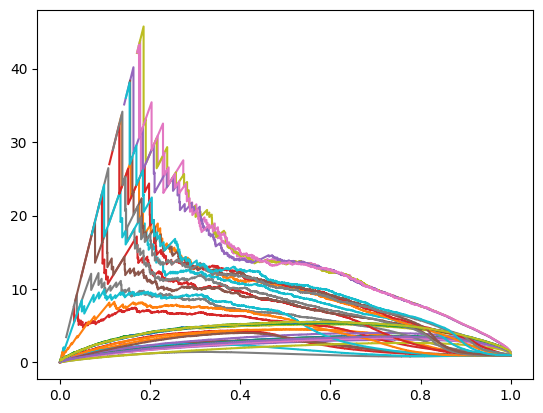

In [26]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

epsilon = 1e-6

# initial_learning_rate = 0.05 #placeholder till callback

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
# )

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR-sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 4.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    #signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]])
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]))])

    print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    msic1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]
# plt.title(f"m1 = {m1} m2 = {m2}")
# plt.xlabel("Average TPR")
# plt.ylabel("Average TPR/sqrt(avg_fpr)")

30338 91014 30 0.0009888588568791614
Epoch 1/35
30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 -

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 8ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6936 - val_loss: 0.6933
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 4/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6939 - val_loss: 0.6935
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6937 - val_loss: 0.6934
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6933
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 8/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 9/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 10/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 2/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6938 - val_loss: 0.6936
Epoch 3/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 5/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 6/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 7/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 7ms/step - loss: 0.6941 - val_loss: 0.6937
Epoch 2/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6939 - val_loss: 0.6937
Epoch 3/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6939 - val_loss: 0.6937
Epoch 4/35
30/30 [==============================] - 0s 4ms/step - loss: 0.6939 - val_loss: 0.6937
Epoch 5/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6939 - val_loss: 0.6936
Epoch 6/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.6936
Epoch 7/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6939 - val_loss: 0.6935
Epoch 8/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.6936
Epoch 9/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.6935
Epoch 10/35
30/30 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.6936
Epoch 11/35
30/30 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 902 0.02973168963016679
Epoch 1/35
31/31 [==============================] - 1s 8ms/step - loss: 0.6946 - val_loss: 0.6938
Epoch 2/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6937
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6940
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6938
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6939
Epoch 6/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6939
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6942 - val_loss: 0.6938
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6938
Epoch 9/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6941 - val_loss: 0.6938
Epoch 10/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6941 - 

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6947 - val_loss: 0.6946
Epoch 2/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6945 - val_loss: 0.6944
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6945 - val_loss: 0.6944
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6945 - val_loss: 0.6945
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6945 - val_loss: 0.6943
Epoch 6/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6945 - val_loss: 0.6943
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6943 - val_loss: 0.6942
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6943
Epoch 9/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6944
Epoch 10/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6944 - val_loss: 0.6945
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6955 - val_loss: 0.6951
Epoch 2/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6951 - val_loss: 0.6950
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6949
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6949
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6949
Epoch 6/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6948
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6948 - val_loss: 0.6949
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6949
Epoch 9/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6949 - val_loss: 0.6948
Epoch 10/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6949 - val_loss: 0.6948
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6963 - val_loss: 0.6959
Epoch 2/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6961 - val_loss: 0.6956
Epoch 3/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6960 - val_loss: 0.6956
Epoch 4/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6959 - val_loss: 0.6954
Epoch 5/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6959 - val_loss: 0.6954
Epoch 6/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6958 - val_loss: 0.6953
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.6954
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.6954
Epoch 9/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6958 - val_loss: 0.6953
Epoch 10/35
31/31 [==============================] - 0s 3ms/step - loss: 0.6958 - val_loss: 0.6953
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 7ms/step - loss: 0.6975 - val_loss: 0.6974
Epoch 2/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6972 - val_loss: 0.6972
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6971 - val_loss: 0.6969
Epoch 4/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6970 - val_loss: 0.6967
Epoch 5/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6969 - val_loss: 0.6967
Epoch 6/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6968
Epoch 7/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6969 - val_loss: 0.6967
Epoch 8/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6969
Epoch 9/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6969
Epoch 10/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6968 - val_loss: 0.6968
Epoch 11/35
31/31 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


32/32 [==============================] - 1s 7ms/step - loss: 0.6995 - val_loss: 0.6988
Epoch 2/35
32/32 [==============================] - 0s 4ms/step - loss: 0.6992 - val_loss: 0.6986
Epoch 3/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6990 - val_loss: 0.6986
Epoch 4/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6989 - val_loss: 0.6984
Epoch 5/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6989 - val_loss: 0.6985
Epoch 6/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6989 - val_loss: 0.6986
Epoch 7/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6990 - val_loss: 0.6985
Epoch 8/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6989 - val_loss: 0.6984
Epoch 9/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6987 - val_loss: 0.6983
Epoch 10/35
32/32 [==============================] - 0s 3ms/step - loss: 0.6987 - val_loss: 0.6984
Epoch 11/35
32/32 [===========

/tmp/ipykernel_375799/70673800.py:91: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_375799/70673800.py:92: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


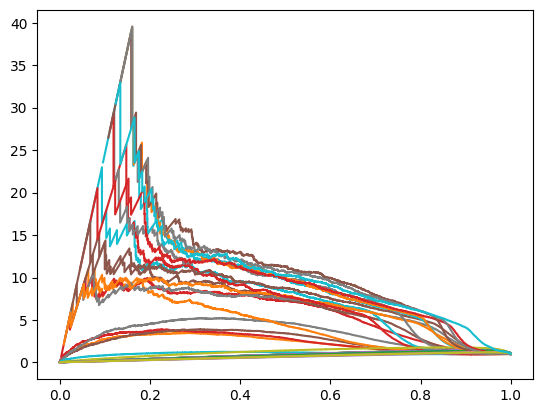

In [52]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

epsilon = 1e-6

# initial_learning_rate = 0.05 #placeholder till callback

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
# )

for sigfrac in np.logspace(-3,-1,20):
    #print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR-sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.02))

    m1 = 3
    m2 = 4.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state=42)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 1)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    msic1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]
# plt.title(f"m1 = {m1} m2 = {m2}")
# plt.xlabel("Average TPR")
# plt.ylabel("Average TPR/sqrt(avg_fpr)")

In [48]:
len(x[0,0]) - test_background - train_reference

30338

In [49]:
train_data

30338

In [50]:
len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)])

3033

In [ ]:
len(x_vals

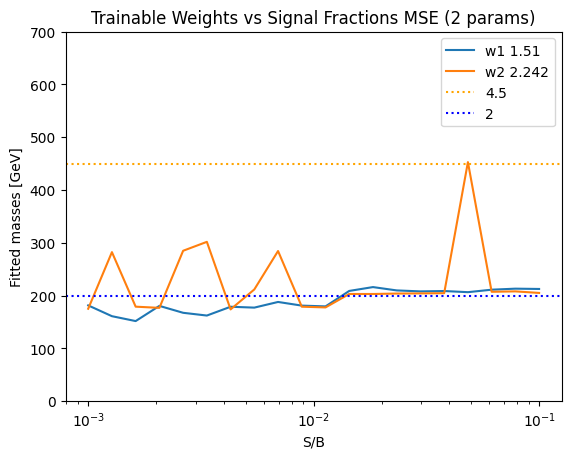

In [60]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'max SIC')

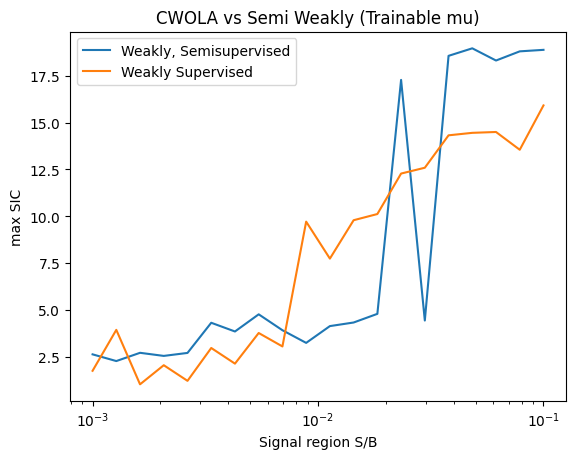

In [56]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

In [ ]:
# plt.plot(xx,np.array(ww))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(xx,xx,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")
# plt.title("S/B vs Fitted S/B")

Text(0, 0.5, 'max SIC')

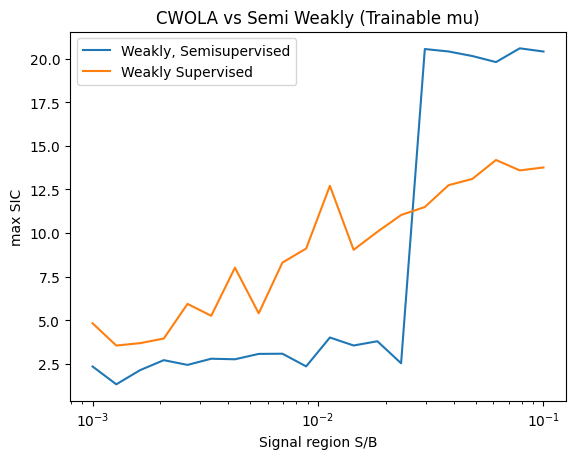

In [115]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

0.824 4.97 0.001
3 4.5 0.6804712 4.9176154
95/95 [==============================] - 0s 820us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 685us/step
0.824 4.97 0.0012742749857031334
3 4.5 1.1553359 5.2989764
95/95 [==============================] - 0s 802us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 682us/step
0.824 4.97 0.001623776739188721
3 4.5 0.87482 4.548716
95/95 [==============================] - 0s 785us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 645us/step
0.824 4.97 0.00206913808111479
3 4.5 0.7642072 5.183907
95/95 [==============================] - 0s 789us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 664us/step
0.824 4.97 0.0026366508987303583
3 4.5 0.7718455 4.892569
95/95 [==============================] - 0s 774us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 671us/step
0.824 4.97 0.003359818286283781
3 4.5 0.70330006 4.6586003
95/95 [==============================] - 0s 743us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 643us/step
0.824 4.97 0.004281332398719396
3 4.5 0.9229536 5.170737
95/95 [==============================] - 0s 792us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 688us/step
0.824 4.97 0.00545559478116852
3 4.5 0.74838454 4.9876065
95/95 [==============================] - 0s 785us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 626us/step
0.824 4.97 0.0069519279617756054
3 4.5 0.99225 5.5927973
95/95 [==============================] - 0s 770us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 703us/step
0.824 4.97 0.008858667904100823
3 4.5 0.7767963 4.888415
95/95 [==============================] - 0s 799us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 641us/step
0.824 4.97 0.011288378916846888
3 4.5 1.0344769 5.0473385
95/95 [==============================] - 0s 720us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 672us/step
0.824 4.97 0.01438449888287663
3 4.5 0.7785829 4.8932376
95/95 [==============================] - 0s 763us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 671us/step
0.824 4.97 0.018329807108324356
3 4.5 0.98659945 4.3595757
95/95 [==============================] - 0s 780us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 651us/step
0.824 4.97 0.023357214690901212
3 4.5 0.7460878 4.7667203
95/95 [==============================] - 0s 785us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 676us/step
0.824 4.97 0.029763514416313176
3 4.5 1.363352 4.407185
95/95 [==============================] - 0s 790us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 638us/step
0.824 4.97 0.0379269019073225
3 4.5 0.726717 4.5440693
95/95 [==============================] - 0s 792us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 665us/step
0.824 4.97 0.04832930238571752
3 4.5 2.2265568 4.565622
95/95 [==============================] - 0s 820us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 677us/step
0.824 4.97 0.06158482110660261
3 4.5 2.9945562 4.5134697
95/95 [==============================] - 0s 767us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 662us/step
0.824 4.97 0.07847599703514611
3 4.5 2.9756694 4.481383
95/95 [==============================] - 0s 807us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 689us/step
0.824 4.97 0.1
3 4.5 2.9973018 4.5042906
95/95 [==============================] - 0s 821us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 695us/step
5.869 0.944 0.001
3 4.5 5.2610893 0.89324635
95/95 [==============================] - 0s 786us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 716us/step
5.869 0.944 0.0012742749857031334
3 4.5 5.5840764 1.2834225
95/95 [==============================] - 0s 770us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 675us/step
5.869 0.944 0.001623776739188721
3 4.5 5.726399 0.9730076
95/95 [==============================] - 0s 774us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 682us/step
5.869 0.944 0.00206913808111479
3 4.5 5.4965334 0.914659
95/95 [==============================] - 0s 965us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 667us/step
5.869 0.944 0.0026366508987303583
3 4.5 5.51752 0.9299412
95/95 [==============================] - 0s 782us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 650us/step
5.869 0.944 0.003359818286283781
3 4.5 6.0639687 1.1448131
95/95 [==============================] - 0s 739us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 688us/step
5.869 0.944 0.004281332398719396
3 4.5 5.2839813 1.3505541
95/95 [==============================] - 0s 844us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 673us/step
5.869 0.944 0.00545559478116852
3 4.5 4.9821887 0.9368646
95/95 [==============================] - 0s 783us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 640us/step
5.869 0.944 0.0069519279617756054
3 4.5 5.681886 0.95520294
95/95 [==============================] - 0s 757us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 640us/step
5.869 0.944 0.008858667904100823
3 4.5 7.0204144 1.0387034
95/95 [==============================] - 0s 776us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 672us/step
5.869 0.944 0.011288378916846888
3 4.5 5.8739777 1.0027978
95/95 [==============================] - 0s 746us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 663us/step
5.869 0.944 0.01438449888287663
3 4.5 4.657791 0.9395103
95/95 [==============================] - 0s 808us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 679us/step
5.869 0.944 0.018329807108324356
3 4.5 5.1151714 1.3911997
95/95 [==============================] - 0s 819us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 733us/step
5.869 0.944 0.023357214690901212
3 4.5 5.621462 1.0446956
95/95 [==============================] - 0s 758us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 666us/step
5.869 0.944 0.029763514416313176
3 4.5 4.6750264 0.7922754
95/95 [==============================] - 0s 768us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 636us/step
5.869 0.944 0.0379269019073225
3 4.5 6.400572 0.93366283
95/95 [==============================] - 0s 800us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 657us/step
5.869 0.944 0.04832930238571752
3 4.5 5.6713915 1.0509071
95/95 [==============================] - 0s 746us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 701us/step
5.869 0.944 0.06158482110660261
3 4.5 4.543046 3.0235968
95/95 [==============================] - 0s 746us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 625us/step
5.869 0.944 0.07847599703514611
3 4.5 4.5049233 2.9857466
95/95 [==============================] - 0s 746us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 637us/step
5.869 0.944 0.1
3 4.5 4.5107236 2.9963806
95/95 [==============================] - 0s 768us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 663us/step
0.796 4.391 0.001
3 4.5 0.6590127 4.0506434
95/95 [==============================] - 0s 773us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 688us/step
0.796 4.391 0.0012742749857031334
3 4.5 1.0510752 4.4024715
95/95 [==============================] - 0s 785us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 699us/step
0.796 4.391 0.001623776739188721
3 4.5 0.7933731 4.64347
95/95 [==============================] - 0s 805us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 667us/step
0.796 4.391 0.00206913808111479
3 4.5 1.3649755 4.5641212
95/95 [==============================] - 0s 819us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 676us/step
0.796 4.391 0.0026366508987303583
3 4.5 1.147993 4.443256
95/95 [==============================] - 0s 786us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 697us/step
0.796 4.391 0.003359818286283781
3 4.5 0.99534386 4.281719
95/95 [==============================] - 0s 814us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 665us/step
0.796 4.391 0.004281332398719396
3 4.5 1.034716 4.4247465
95/95 [==============================] - 0s 787us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 633us/step
0.796 4.391 0.00545559478116852
3 4.5 0.80096614 4.639595
95/95 [==============================] - 0s 759us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 687us/step
0.796 4.391 0.0069519279617756054
3 4.5 0.7338131 4.6315193
95/95 [==============================] - 0s 790us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 642us/step
0.796 4.391 0.008858667904100823
3 4.5 0.75155586 4.597438
95/95 [==============================] - 0s 761us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 683us/step
0.796 4.391 0.011288378916846888
3 4.5 0.7424583 4.3209176
95/95 [==============================] - 0s 809us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 672us/step
0.796 4.391 0.01438449888287663
3 4.5 0.7765953 4.6192355
95/95 [==============================] - 0s 825us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 689us/step
0.796 4.391 0.018329807108324356
3 4.5 0.8468149 4.4280763
95/95 [==============================] - 0s 713us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 675us/step
0.796 4.391 0.023357214690901212
3 4.5 0.7403996 4.432555
95/95 [==============================] - 0s 794us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 649us/step
0.796 4.391 0.029763514416313176
3 4.5 0.77078825 4.491417
95/95 [==============================] - 0s 750us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 643us/step
0.796 4.391 0.0379269019073225
3 4.5 1.4738141 4.446988
95/95 [==============================] - 0s 787us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 691us/step
0.796 4.391 0.04832930238571752
3 4.5 0.7641986 4.5838223
95/95 [==============================] - 0s 793us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 683us/step
0.796 4.391 0.06158482110660261
3 4.5 0.76100856 4.4703712
95/95 [==============================] - 0s 723us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 648us/step
0.796 4.391 0.07847599703514611
3 4.5 3.0345333 4.4882827
95/95 [==============================] - 0s 807us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 662us/step
0.796 4.391 0.1
3 4.5 3.0077314 4.5009775
95/95 [==============================] - 0s 786us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 659us/step
3.13 3.2 0.001
3 4.5 3.065446 3.118749
95/95 [==============================] - 0s 826us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 673us/step
3.13 3.2 0.0012742749857031334
3 4.5 2.9465294 3.2513576
95/95 [==============================] - 0s 832us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 636us/step
3.13 3.2 0.001623776739188721
3 4.5 3.438064 3.443459
95/95 [==============================] - 0s 737us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 686us/step
3.13 3.2 0.00206913808111479
3 4.5 3.2823904 3.5735855
95/95 [==============================] - 0s 768us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 669us/step
3.13 3.2 0.0026366508987303583
3 4.5 2.9229245 4.184212
95/95 [==============================] - 0s 788us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 603us/step
3.13 3.2 0.003359818286283781
3 4.5 2.9078317 3.1120124
95/95 [==============================] - 0s 725us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 651us/step
3.13 3.2 0.004281332398719396
3 4.5 2.9466496 3.130559
95/95 [==============================] - 0s 792us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 666us/step
3.13 3.2 0.00545559478116852
3 4.5 2.989805 3.2024508
95/95 [==============================] - 0s 777us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 708us/step
3.13 3.2 0.0069519279617756054
3 4.5 3.3156724 3.267464
95/95 [==============================] - 0s 802us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 665us/step
3.13 3.2 0.008858667904100823
3 4.5 3.0587673 3.4867058
95/95 [==============================] - 0s 778us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 686us/step
3.13 3.2 0.011288378916846888
3 4.5 2.918291 3.1239324
95/95 [==============================] - 0s 781us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 654us/step
3.13 3.2 0.01438449888287663
3 4.5 3.0074394 4.536382
95/95 [==============================] - 0s 761us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 695us/step
3.13 3.2 0.018329807108324356
3 4.5 3.0095923 4.56755
95/95 [==============================] - 0s 777us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 725us/step
3.13 3.2 0.023357214690901212
3 4.5 3.0132422 4.558969
95/95 [==============================] - 0s 788us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 636us/step
3.13 3.2 0.029763514416313176
3 4.5 3.0512753 3.1151178
95/95 [==============================] - 0s 786us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 2s 670us/step
3.13 3.2 0.0379269019073225
3 4.5 3.0996673 3.1601973
95/95 [==============================] - 0s 814us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 668us/step
3.13 3.2 0.04832930238571752
3 4.5 3.0537634 3.1353548
95/95 [==============================] - 0s 730us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 691us/step
3.13 3.2 0.06158482110660261
3 4.5 3.0238948 4.528845
95/95 [==============================] - 0s 780us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 683us/step
3.13 3.2 0.07847599703514611
3 4.5 3.014979 4.509576
95/95 [==============================] - 0s 820us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 661us/step
3.13 3.2 0.1
3 4.5 3.003907 4.491857
95/95 [==============================] - 0s 921us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 689us/step
3.36 1.001 0.001
3 4.5 3.6406171 1.1662093
95/95 [==============================] - 0s 819us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 629us/step
3.36 1.001 0.0012742749857031334
3 4.5 2.4602191 0.9737373
95/95 [==============================] - 0s 788us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 684us/step
3.36 1.001 0.001623776739188721
3 4.5 2.9365575 1.0842417
95/95 [==============================] - 0s 770us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 631us/step
3.36 1.001 0.00206913808111479
3 4.5 3.671143 1.3522428
95/95 [==============================] - 0s 809us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 683us/step
3.36 1.001 0.0026366508987303583
3 4.5 3.3106716 0.98719305
95/95 [==============================] - 0s 751us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 665us/step
3.36 1.001 0.003359818286283781
3 4.5 3.7709084 1.2606026
95/95 [==============================] - 0s 734us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 680us/step
3.36 1.001 0.004281332398719396
3 4.5 3.61645 1.2917435
95/95 [==============================] - 0s 779us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 681us/step
3.36 1.001 0.00545559478116852
3 4.5 3.4643617 1.195723
95/95 [==============================] - 0s 784us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 667us/step
3.36 1.001 0.0069519279617756054
3 4.5 3.7364893 1.1606745
95/95 [==============================] - 0s 758us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 695us/step
3.36 1.001 0.008858667904100823
3 4.5 3.0641508 1.5653602
95/95 [==============================] - 0s 786us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 650us/step
3.36 1.001 0.011288378916846888
3 4.5 3.1513295 0.5419889
95/95 [==============================] - 0s 798us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 675us/step
3.36 1.001 0.01438449888287663
3 4.5 3.676235 1.3382375
95/95 [==============================] - 2s 778us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 676us/step
3.36 1.001 0.018329807108324356
3 4.5 3.2670252 1.5319321
95/95 [==============================] - 0s 784us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 689us/step
3.36 1.001 0.023357214690901212
3 4.5 3.750577 1.2928176
95/95 [==============================] - 0s 757us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 668us/step
3.36 1.001 0.029763514416313176
3 4.5 3.0630062 1.0419242
95/95 [==============================] - 0s 784us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 672us/step
3.36 1.001 0.0379269019073225
3 4.5 3.1657 1.2891251
95/95 [==============================] - 0s 794us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 612us/step
3.36 1.001 0.04832930238571752
3 4.5 3.0166662 0.90928
95/95 [==============================] - 0s 760us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 628us/step
3.36 1.001 0.06158482110660261
3 4.5 2.9201508 0.8934062
95/95 [==============================] - 0s 788us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 682us/step
3.36 1.001 0.07847599703514611
3 4.5 4.47753 3.0323837
95/95 [==============================] - 0s 816us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 685us/step
3.36 1.001 0.1
3 4.5 3.2003825 1.658555
95/95 [==============================] - 0s 776us/step


/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/2100830154.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 671us/step


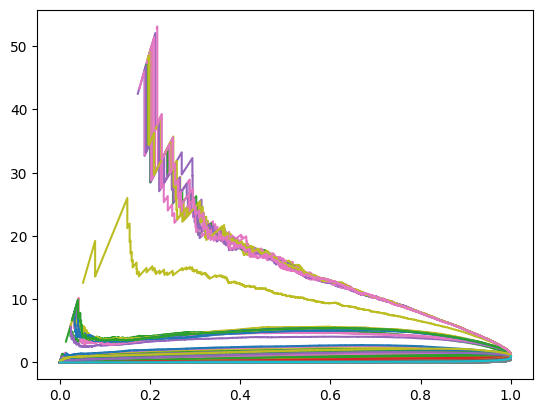

In [122]:
num_runs = 5
scores_list_runs = []

msic1_list_runs = []
msic2_list_runs = []

for _ in range(num_runs):

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []
    
    score_list = []
    
#     initial_learning_rate = 0.05 #placeholder till callback

#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
#     )

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    
    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1.+sigfrac*LLR-sigfrac
        #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 4.5

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        #signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]])
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]))])

        #print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        
        score_list.append(scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,fpr)
        #plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
        msic2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]
        
    msic1_list_runs.append(msic1)
    msic2_list_runs.append(msic2)
    scores_list_runs.append(score_list)

/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_339593/1089124578.py:4: Runti

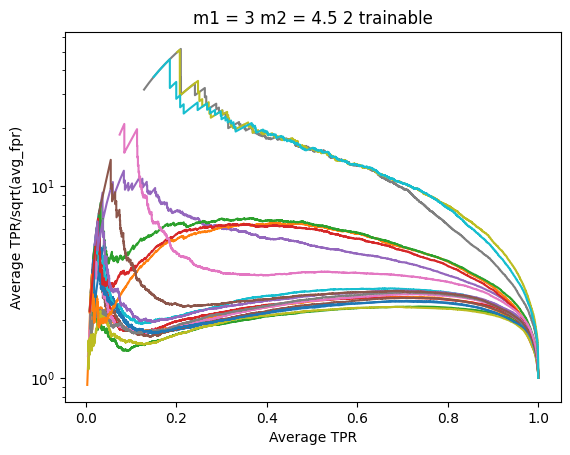

In [123]:
avg = np.mean(scores_list_runs, axis = 0)
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
    plt.title(f"m1 = {m1} m2 = {m2} 2 trainable")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")

In [152]:
# avgmsic1 = np.mean(msic1_list_runs, axis = 0)
# avgmsic2 = np.mean(msic2_list_runs, axis = 0)

# plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
# plt.plot(xx,avgmsic2,label="Weakly Supervised")
# plt.title("CWOLA vs Semi Weakly (5 Runs 2 Trainable)")
# plt.legend()
# plt.xscale("log")
# plt.xlabel("Signal region S/B")
# plt.ylabel("Avg Max SIC")